In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Connect to / create database
conn = sqlite3.connect('dataverse.db')
c = conn.cursor()

In [3]:
# Fetch data of diverted flights
c.execute('''
SELECT Year, Month, DayofMonth, CRSDepTime, CRSArrTime, Distance, UniqueCarrier, Origin,
Dest, Diverted
FROM flights
WHERE Cancelled = 0 AND Diverted = 1 AND Distance != 'NA';
''')

# Put results into dataframe
a = c.fetchall()
diverted = pd.DataFrame(a, columns = ['Year', 'Month', 'DayofMonth', 'CRSDepTime', 'CRSArrTime', 
                                      'Distance', 'UniqueCarrier', 'Origin', 'Dest', 'Diverted'])
diverted

,Year,Month,DayofMonth,CRSDepTime,CRSArrTime,Distance,UniqueCarrier,Origin,Dest,Diverted
0,1995,1,4,850,1100,1671,HP,CMH,PHX,1
1,1995,1,13,750,935,1020,WN,HOU,PHX,1
2,1995,1,4,1600,1745,1020,WN,HOU,PHX,1
3,1995,1,19,1600,1740,1020,WN,HOU,PHX,1
4,1995,1,1,1235,1415,1020,WN,HOU,PHX,1
...,...,...,...,...,...,...,...,...,...,...
124076,2004,12,14,1555,1848,952,DL,MHT,ATL,1
124077,2004,12,15,1648,1957,2446,DL,JFK,SAN,1
124078,2004,12,15,1850,1944,626,DL,SLC,SAN,1
124079,2004,12,15,2045,2136,626,DL,SLC,SAN,1


In [ ]:
# Fetch random sample of non diverted flights where row count = diverted flights
c.execute('''
SELECT Year, Month, DayofMonth, CRSDepTime, CRSArrTime, Distance, UniqueCarrier, Origin,
Dest, Diverted
FROM flights
WHERE Cancelled = 0 AND Diverted = 0 AND Distance != 'NA'
ORDER BY RANDOM()
LIMIT (SELECT COUNT(*) FROM flights WHERE Diverted = 1 AND Distance != 'NA');
''')

# Put results into dataframe
b = c.fetchall()
notdiverted = pd.DataFrame(b, columns = ['Year', 'Month', 'DayofMonth', 'CRSDepTime', 'CRSArrTime', 
                                      'Distance', 'UniqueCarrier', 'Origin', 'Dest', 'Diverted'])
notdiverted

In [7]:
# Combine dataframes
flightsdata = pd.concat([diverted, notdiverted])

# Take top 5 most occurring Carriers, Origin, Dest
topoccur = {col: list(flightsdata[col].value_counts().head(5).index) for col in ["UniqueCarrier", 
                                                                                 "Origin", "Dest"]}

# Perform one-hot encoding
for col in topoccur.keys():
    flightsdata[f"Top5{col}"] = np.where(flightsdata[col].isin(topoccur[col]), 1, 0)

flightsdata

,Year,Month,DayofMonth,CRSDepTime,CRSArrTime,Distance,UniqueCarrier,Origin,Dest,Diverted,Top5UniqueCarrier,Top5Origin,Top5Dest
0,1995,1,4,850,1100,1671,HP,CMH,PHX,1,0,0,0
1,1995,1,13,750,935,1020,WN,HOU,PHX,1,1,0,0
2,1995,1,4,1600,1745,1020,WN,HOU,PHX,1,1,0,0
3,1995,1,19,1600,1740,1020,WN,HOU,PHX,1,1,0,0
4,1995,1,1,1235,1415,1020,WN,HOU,PHX,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124076,2000,11,17,725,735,325,WN,PHX,ONT,0,1,1,0
124077,1995,11,20,2130,2154,425,DL,ATL,MSY,0,1,1,0
124078,1996,9,13,1810,2103,1011,US,LGA,TPA,0,1,0,0
124079,2003,7,30,1850,1904,240,MQ,DAY,ORD,0,0,0,1


In [8]:
# Convert Diverted and encoded columns to categorical
flightsdata["Diverted"] = flightsdata["Diverted"].astype("category")
flightsdata[f"Top5UniqueCarrier"] = flightsdata[f"Top5UniqueCarrier"].astype("category")
flightsdata[f"Top5Origin"] = flightsdata[f"Top5Origin"].astype("category")
flightsdata[f"Top5Dest"] = flightsdata[f"Top5Dest"].astype("category")

# Check if conversion worked
flightsdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248162 entries, 0 to 124080
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Year               248162 non-null  int64   
 1   Month              248162 non-null  int64   
 2   DayofMonth         248162 non-null  int64   
 3   CRSDepTime         248162 non-null  int64   
 4   CRSArrTime         248162 non-null  int64   
 5   Distance           248162 non-null  int64   
 6   UniqueCarrier      248162 non-null  object  
 7   Origin             248162 non-null  object  
 8   Dest               248162 non-null  object  
 9   Diverted           248162 non-null  category
 10  Top5UniqueCarrier  248162 non-null  category
 11  Top5Origin         248162 non-null  category
 12  Top5Dest           248162 non-null  category
dtypes: category(4), int64(6), object(3)
memory usage: 19.9+ MB


In [9]:
# Split data into training and test sets
trainflights, testflights = train_test_split(flightsdata, test_size = 0.3, random_state = 110, 
                                             stratify = flightsdata["Diverted"])

In [10]:
# Logistics Regression Model
logreg = sm.Logit(trainflights["Diverted"], 
                  sm.add_constant(trainflights[["Year", "Month", "DayofMonth", "CRSDepTime", 
                                                "CRSArrTime", "Distance", "Top5UniqueCarrier", 
                                                "Top5Origin", "Top5Dest"]]))
model = logreg.fit()

# Summary of logistics regression model
model.summary()

Optimization terminated successfully.
         Current function value: 0.674077
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Diverted   No. Observations:               173713
Model:                          Logit   Df Residuals:                   173703
Method:                           MLE   Df Model:                            9
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                 0.02751
Time:                        22:34:58   Log-Likelihood:            -1.1710e+05
converged:                       True   LL-Null:                   -1.2041e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                61.0088      3.431     17.784      0.000      54.285      67.732
Year                 -0.0308      0.002    -17.954      0.000      -0.034      -0.027
Month                -0.0138      0.001     -9.674      0.000      -0.017      -0.011
DayofMonth           -0.0011      0.001     -1.867      0.062      -0.002    5.23e-05
CRSDepTime            -1e-05   1.61e-05     -0.620      0.535   -4.16e-05    2.16e-05
CRSArrTime            0.0002   1.52e-05     10.787      0.000       0.000       0.000
Distance              0.0006   8.57e-06     68.742      0.000       0.001       0.001
Top5UniqueCarrier    -0.0820      0.010     -7.856      0.000      -0.102      -0.062
Top5Origin           -0.1904      0.012    -15.396      0.000      -0.215      -0.166
Top5Dest              0.2309      0.012     19.511      0.000       0.208       0.254
=====================================================================================
"""

In [11]:
# Predict probabilities for the test set
probabilities = model.predict(sm.add_constant(testflights[["Year", "Month", "DayofMonth", 
                                                            "CRSDepTime", "CRSArrTime", "Distance", 
                                                            "Top5UniqueCarrier", "Top5Origin", 
                                                            "Top5Dest"]]))
# Convert probabilities to class labels
predictions = (probabilities > 0.5).astype(int)

# True results
true = testflights["Diverted"].cat.codes

# Calculate metrics
Accuracy = accuracy_score(true, predictions)
Precision = precision_score(true, predictions)
Recall = recall_score(true, predictions)
F1Score = f1_score(true, predictions)
AUC = roc_auc_score(true, probabilities)

# Print results
metrics = pd.DataFrame({"Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
                           "Value": [Accuracy, Precision, Recall, F1Score, AUC]})

metrics

,Metric,Value
0,Accuracy,0.584373
1,Precision,0.596385
2,Recall,0.522029
3,F1 Score,0.556735
4,AUC,0.611056


Optimization terminated successfully.
         Current function value: 0.658869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676229
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673496
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.674821
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660427
  

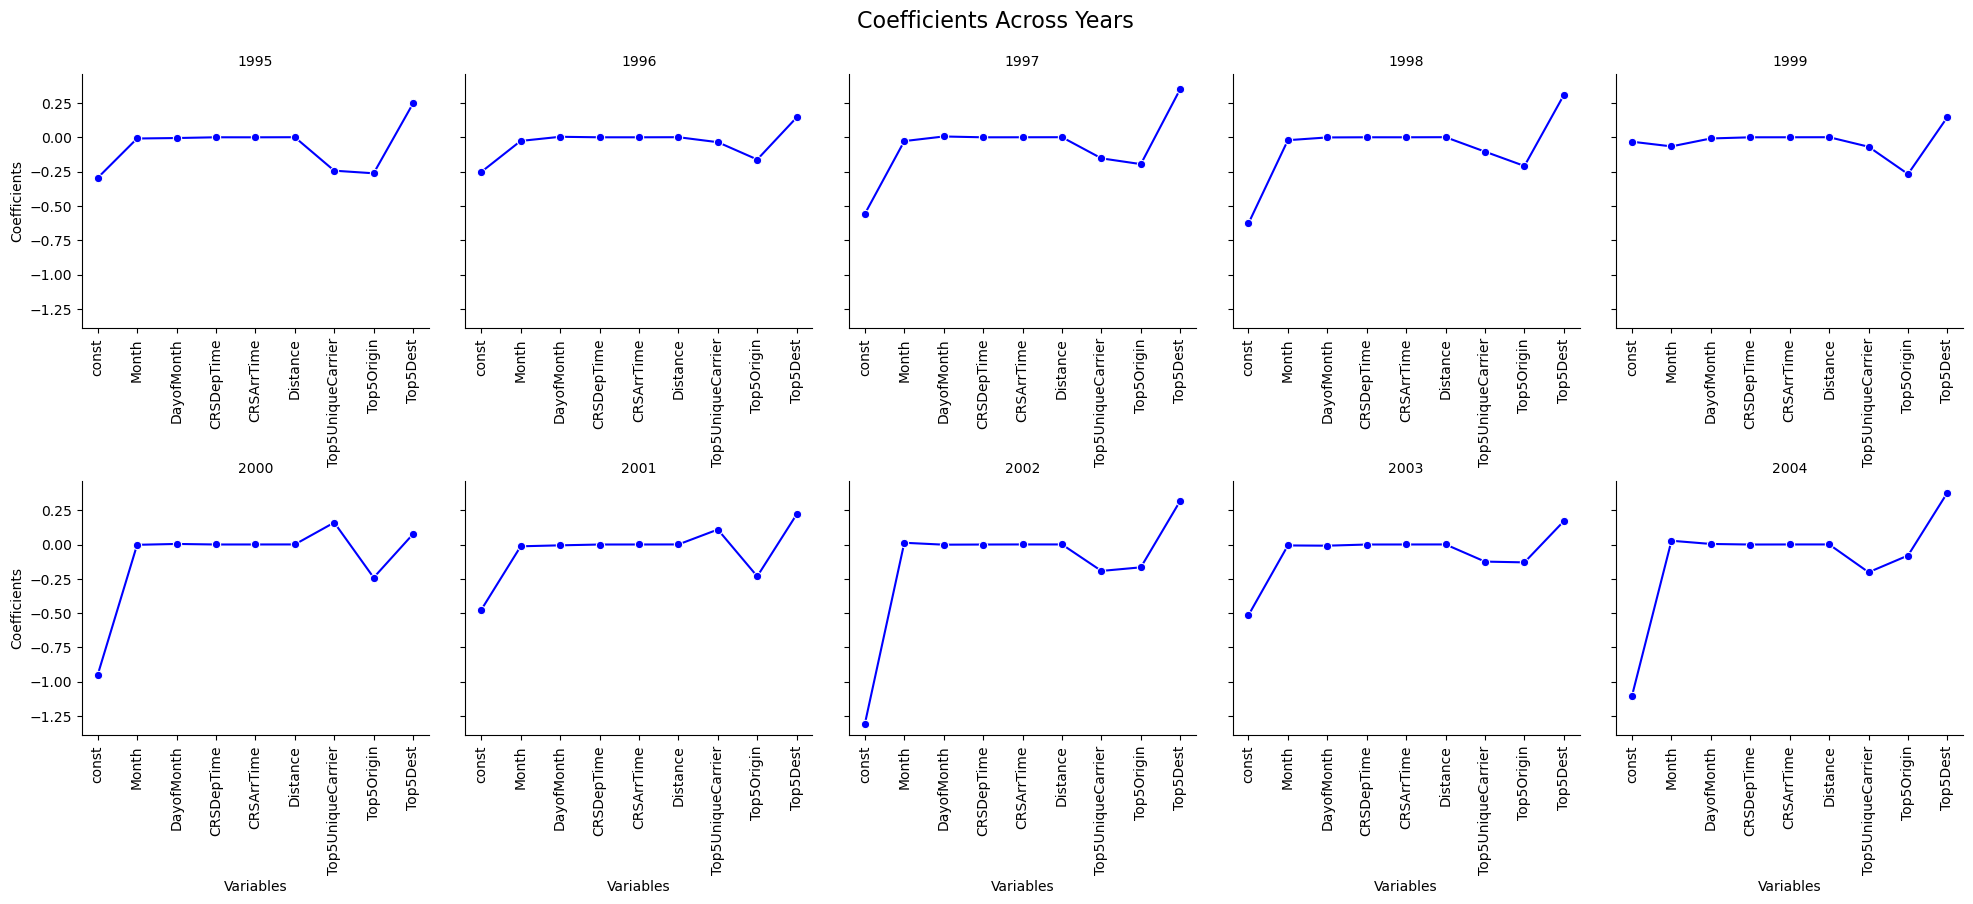

In [12]:
# Function to get coefficients for each year
def get_coefficients(logregplot):
    coefficients = logregplot.params
    return coefficients

# Get coefficients for each year
yearcoefficients = []
for year in trainflights["Year"].unique():
    plotsubset = trainflights[trainflights["Year"] == year]
    logregplot = sm.Logit(plotsubset["Diverted"], sm.add_constant(plotsubset[["Month", "DayofMonth", 
                                                                      "CRSDepTime", "CRSArrTime", 
                                                                      "Distance", "Top5UniqueCarrier", 
                                                                      "Top5Origin", "Top5Dest"]]))
    plotmodel = logregplot.fit()
    coefficients = get_coefficients(plotmodel)
    yearcoefficients.append(pd.DataFrame({"Year": year, "Variables": coefficients.index, 
                                           "Coefficients": coefficients.values}))

# Combine coefficients into a dataframe
dfcoefficients = pd.concat(yearcoefficients)

# Plot 
y = sns.FacetGrid(dfcoefficients, col = "Year", col_wrap = 5, height = 4)
y.map(sns.lineplot, "Variables", "Coefficients", marker = 'o', color = 'blue')
y.set_titles("{col_name}")
y.set_axis_labels('Variables' ,'Coefficients')
plt.subplots_adjust(top = 0.9, hspace = 0.6)
y.fig.suptitle('Coefficients Across Years', fontsize = 16)
for ax in y.axes.flat:
    ax.xaxis.set_tick_params(labelbottom = True, rotation = 90)
plt.show()

In [13]:
conn.close()